# Visualization of Chrome Browser History

## Setup and Data Loading

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Path to the JSON data file containing the browser history
history_json_path = '../data/Chrome/History.json'
# Path to the CSV file containing top-level domains (TLDs)
tld_csv_path = '../data/tlds.csv'

# Load browser history from JSON file
with open(history_json_path, 'r') as file:
    browser_history = json.load(file).get('Browser History')

# Convert the history to a pandas DataFrame and drop irrelevant columns
history_df = pd.DataFrame(browser_history).drop(columns=['client_id'])

# Sort DataFrame by 'time_usec' in ascending order
history_df.sort_values(by='time_usec', ascending=True, inplace=True)

# Display the first 5 rows of the DataFrame
# print(history_df.head(5))

## Domain Extraction and Data Processing

In [2]:
# Load top-level domains (TLDs) from CSV file
# extracted from 'https://www.iana.org/domains/root/db'
# code: tlds_extractor.ipynb (in the same directory)

tlds_df = pd.read_csv(tld_csv_path, header=None)
tlds_list = tlds_df[0].str.lower().tolist()

def extract_domain_name(url):
    """
    Extracts the domain name from a URL, excluding subdomains and the top-level domain (TLD).
    
    Parameters:
        url (str): The URL from which the domain name will be extracted.
    
    Returns:
        str: The extracted domain name or an empty string if extraction fails.
    """
    try:
        primary_domain_components = url.split('://')[-1].split('/')[0].split('.')
        extracted_primary_domain = ''
        for i, component in enumerate(primary_domain_components):
            if component in tlds_list and primary_domain_components[i-1] != 'www':
                match primary_domain_components[i]:
                    case 'google':
                        extracted_primary_domain = 'google'
                        break
                    case 'youtube':
                        extracted_primary_domain = 'youtube'
                        break
                    case 'yahoo':
                        extracted_primary_domain = 'yahoo'
                        break
                    case 'bing':
                        extracted_primary_domain = 'bing'
                        break
                    case 'imdb':
                        extracted_primary_domain = 'imdb'
                        break
                    case _:
                        pass
                extracted_primary_domain = primary_domain_components[i-1]
                if extracted_primary_domain in tlds_list:
                    continue
                break
        return extracted_primary_domain
    except Exception as e:
        print(f'Error extracting domain from URL {url}: {e}')
    return ''

# Apply domain name extraction to URLs
history_df['domain'] = history_df['url'].apply(extract_domain_name)

# Convert 'time_usec' to human-readable date format (Month Year)
history_df['visit_date'] = pd.to_datetime(history_df['time_usec'], unit='us').dt.strftime('%b %Y')

# Filter out rows with irrelevant URLs
filtered_df = history_df[~history_df['url'].str.contains('localhost|chrome://|about:blank|about:newtab|chrome://newtab/|chrome-extension://')]

# Display the processed DataFrame
# print(filtered_df.head(5))

## Aggregating and Visualizing Website Visit Data

In [3]:
def aggregate_visit_data(df):
    """
    Aggregates website visit data by domain and visit date.
    
    Parameters:
        df (DataFrame): The DataFrame containing website visit data.
    
    Returns:
        dict: A dictionary with domains as keys and dictionaries of visit dates and counts as values.
    """
    visit_data = {}
    for index, row in df.iterrows():
        domain = row['domain']
        visit_date = row['visit_date']
        if domain not in visit_data:
            visit_data[domain] = {}
        if visit_date not in visit_data[domain]:
            visit_data[domain][visit_date] = 0
        visit_data[domain][visit_date] += 1
    return visit_data

# Aggregate website visit data
visit_data = aggregate_visit_data(filtered_df)

# Sort domains by total visits in descending order
sorted_domains = sorted(visit_data.keys(), key=lambda domain: sum(visit_data[domain].values()), reverse=True)

### Plotting Monthly Activity for Top Websites

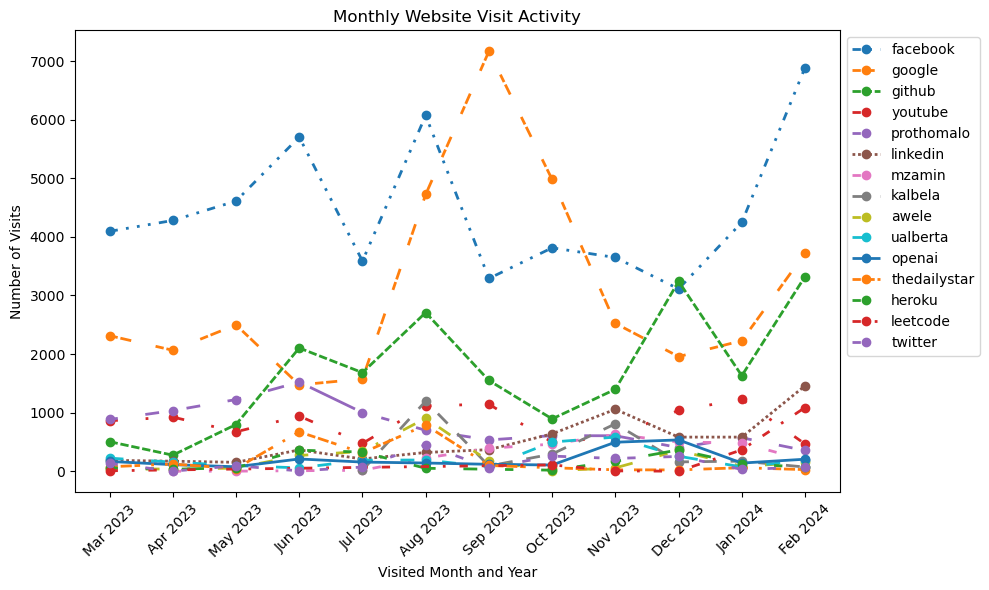

In [4]:
linestyle_tuples = [
    ('solid', (0, ())),
    ('dotted', (0, (1, 1))),
    ('dashed', (0, (5, 5))),
    ('dashdot', (0, (3, 5, 1, 5))),
    ('densely dashed', (0, (3, 1))),
    ('loosely dashed', (0, (5, 10))),
    ('densely dashdot', (0, (3, 1, 4, 9))),
    ('loosely dashdot', (0, (3, 10, 1, 10))),
    ('densely dashdotdot', (0, (3, 1, 4, 1, 4, 1))),
    ('loosely dashdotdot', (0, (3, 10, 3, 10, 2, 10))),
    ('densely dashdotdotdot', (0, (3, 1, 1, 4, 2, 4, 9, 3))),
    ('loosely dashdotdotdot', (0, (3, 10, 1, 10, 3, 10, 1, 10))),
    ('densely dashdotdotdotdot', (0, (3, 1, 4, 1, 2, 4, 1, 4, 1, 4))),
    ('loosely dashdotdotdotdot', (0, (3, 10, 5, 10, 1, 10, 5, 10, 5, 10))),
    ('densely dashdotdotdotdotdot', (0, (3, 10, 5, 10, 5, 10, 5, 10, 6, 10, 18, 10))),
    ('loosely dashdotdotdotdotdot', (0, (3, 10, 3, 10, 8, 10, 5, 10, 3, 10, 3, 10))),
    ('densely dashdotdotdotdotdotdot', (0, (3, 3, 1, 3, 1, 3, 1, 3)))
]

def plot_monthly_activity(visit_data, top_n=10, exclude_current_month=False):
    """
    Plots the monthly activity for the top N websites.
    
    Parameters:
        visit_data (dict): Aggregated visit data.
        top_n (int): The number of top websites to plot.
    """
    current_month = pd.Timestamp.now().strftime('%b %Y')
    
    np. random.seed(3)
    
    styles = np.random.choice(range(len(linestyle_tuples)), size=top_n, replace=False)
    # print(styles)

    plt.figure(figsize=(10, 6))
    for i, domain in enumerate(sorted_domains[:top_n]):
        months = list(visit_data[domain].keys())
        activities = list(visit_data[domain].values())
        
        if exclude_current_month and current_month in months:
            month_index = months.index(current_month)
            months = months[:month_index]
            activities = activities[:month_index]
        # print(i, domain)
        plt.plot(months, activities, label=domain, marker = 'o', linestyle=linestyle_tuples[styles[i]][1], linewidth=2)
    
    plt.xticks(rotation=45)
    plt.xlabel('Visited Month and Year')
    plt.ylabel('Number of Visits')
    plt.title('Monthly Website Visit Activity')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

# Plot the activity for the top visited websites
plot_monthly_activity(visit_data, top_n=15, exclude_current_month=True)


### Answering Questions
- What are the most visited websites?
    - The most visited website for me 'Google' so far.

- If it is 'Google', what is the trend of Google visits after I started using ChatGPT (OpenAI)?
    - To answer that, plot the trend of Google and OpenAI visits only.


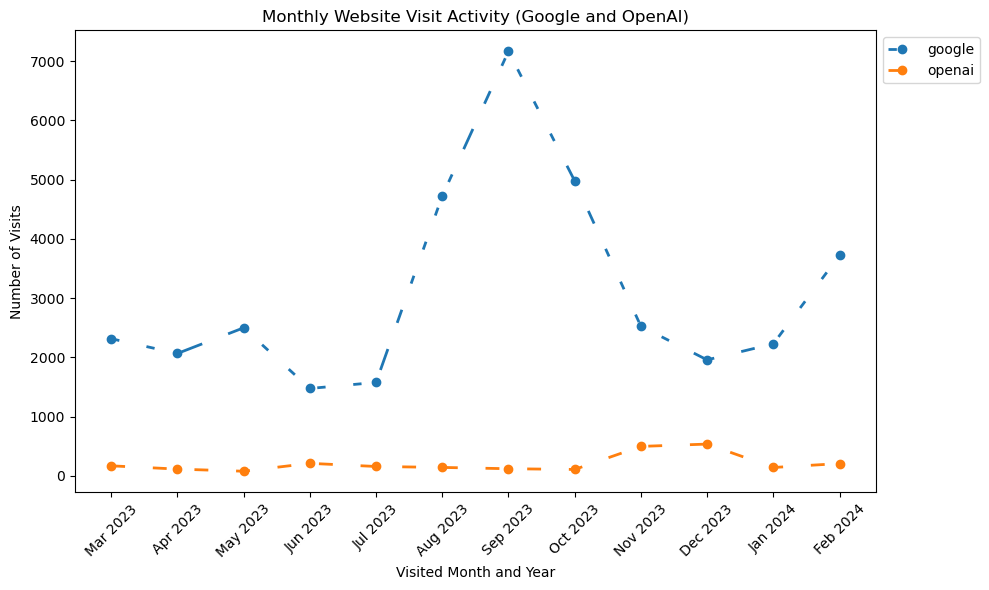

In [5]:
# Plot the trend of Google and OpenAI visits only
plt.figure(figsize=(10, 6))
styles = np.random.choice(range(len(linestyle_tuples)), size=2, replace=False)
current_month = pd.Timestamp.now().strftime('%b %Y')
exclude_current_month = True

for i, domain in enumerate(['google', 'openai']):
    months = list(visit_data[domain].keys())
    activities = list(visit_data[domain].values())
    
    if exclude_current_month and current_month in months:
        month_index = months.index(current_month)
        months = months[:month_index]
        activities = activities[:month_index]
    
    plt.plot(months, activities, label=domain, marker = 'o', linestyle=linestyle_tuples[styles[i]][1], linewidth=2)
plt.xticks(rotation=45)
plt.xlabel('Visited Month and Year')
plt.ylabel('Number of Visits')
plt.title('Monthly Website Visit Activity (Google and OpenAI)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


## Conclusion
Although, the data shows that Google is still the most visited website, the trend of Google visits after I started using ChatGPT (OpenAI) is decreasing. After starting to use ChatGPT Premium ( on September 2023), the number of visits to Google has decreased significantly.